# Exploratory analysis of single cell data with SAUCIE

In this notebook, we will use SAUCIE, a multitasking neural network, that can be used for visualization, clustering, batch correction and denoising of single cell data. We will apply it once again to the Shekhar et al. retinal bipolar data.

## 1. Imports

In [ ]:
!pip install scprep
!pip install tensorflow==1.12.0

In [2]:
import scprep
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import sklearn.manifold
import h5py
import pandas as pd
import os
import sys
import scprep
import tensorflow as tf

SAUCIE is not available on PyPi, but we can download it from GitHub and add it to our Python path to run it without any further installation.

In [ ]:
# download SAUCIE from Github
!git clone https://github.com/KrishnaswamyLab/SAUCIE.git

In [5]:
# add SAUCIE to the python path
sys.path.append('./SAUCIE')

In [6]:
# SAUCIE imports
from model import SAUCIE
from loader import Loader
%matplotlib inline

In [3]:
scprep.io.download.download_google_drive("1GYqmGgv-QY6mRTJhOCE1sHWszRGMFpnf", "data.pickle.gz")
scprep.io.download.download_google_drive("1q1N1s044FGWzYnQEoYMDJOjdWPm_Uone", "metadata.pickle.gz")

In [10]:
data_raw = pd.read_pickle("data.pickle.gz")
data_raw.head()

,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610030E20Rik,...,mt-Tl1,mt-Tl2,mt-Tm,mt-Tp,mt-Tq,mt-Ts2,mt-Tt,mt-Tv,mt-Tw,mt-Ty
Bipolar1_CTCCTAAACAAG,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Bipolar1_CTCGAGAGGCGC,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Bipolar1_AGCCTAAAGTAC,0.0,0.0,0.0,0.0,0.0,0.0,2.671658,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Bipolar1_CGTGAAAATCAA,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,2.670705,0.0,0.0,0.0,0.0,0.0,0.0
Bipolar1_CAACGTTCCGTA,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
metadata = pd.read_pickle("metadata.pickle.gz")
metadata['batch'] = [int(index[7]) for index in metadata.index]
metadata['sample'] = np.where(metadata['batch'] < 4, 'Sample1', 'Sample2')
metadata.head()

,CLUSTER,SUB-CLUSTER,CELLTYPE,batch,sample
Bipolar1_CTCCTAAACAAG,3.0,3,BC5A,1,Sample1
Bipolar1_CTCGAGAGGCGC,9.0,9,BC1B,1,Sample1
Bipolar1_AGCCTAAAGTAC,5.0,5,BC6,1,Sample1
Bipolar1_CGTGAAAATCAA,1.0,1,Rod BC,1,Sample1
Bipolar1_CAACGTTCCGTA,5.0,5,BC6,1,Sample1


In [14]:
data = scprep.reduce.pca(data_raw, n_components=100, method='dense').to_numpy()
data

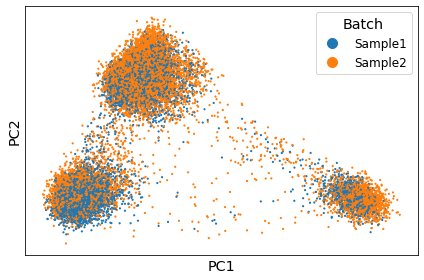

In [15]:
scprep.plot.scatter2d(data, c=metadata['sample'], ticks=False, label_prefix="PC", legend_title="Batch")

In [9]:
# use the handy little loader class
# in training: get random order
# to evaluate: get same order, so we know which row is which
loader_train = Loader(data, labels=metadata['sample'], shuffle=True)
loader_eval = Loader(data, labels=metadata['sample'], shuffle=False)

In [ ]:
# visualize data
# batches are separated in raw data

tf.reset_default_graph()
model = SAUCIE(loader_train.data[0].shape[1])
model.train(loader_train, steps=1000)
embedding, _ = model.get_embedding(loader_eval)

scprep.plot.scatter2d(embedding, c=metadata['sample'], cmap='bwr', ticks=False, label_prefix="SAUCIE")

In [ ]:
# do saucie batch correction

# compile the tf computations for saucie
tf.reset_default_graph()
model = SAUCIE(loader_train.data[0].shape[1], lambda_b=1)

# train the data
model.train(loader_train, steps=2000)

# get the output
data_reconstructed, _ = model.get_reconstruction(loader_eval)

In [ ]:
# visualize the data again
# no more separation between batches

# create loaders for batch-corrected data
loader_train = Loader(data_reconstructed, labels=metadata['sample'], shuffle=True)
loader_eval = Loader(data_reconstructed, labels=metadata['sample'], shuffle=False)

# compile tf computations for saucie
tf.reset_default_graph()
model = SAUCIE(loader_train.data[0].shape[1])
model.train(loader_train, steps=1000)
embedding, _ = model.get_embedding(loader_eval)

scprep.plot.scatter2d(embedding, 
                      c=metadata['sample'], cmap='bwr',
                      ticks=False, label_prefix="SAUCIE")

In [ ]:
# now let's do the clustering

# rescale the data for better clustering
data_scaled = data / data.max() * 10
loader_train = Loader(data_scaled, labels=metadata['sample'], shuffle=True)
loader_eval = Loader(data_scaled, labels=metadata['sample'], shuffle=False)


# compile the tf computations for the clustering model
tf.reset_default_graph()
model = SAUCIE(loader_train.data[0].shape[1], lambda_c=.1, lambda_d=.5)

# train the clustering model
model.train(loader_train, steps=5000)

# get the clusters out
_, clusters = model.get_clusters(loader_eval, binmin=10)
embedding, _ = model.get_embedding(loader_eval)

In [ ]:
scprep.plot.scatter2d(embedding, c=clusters, ticks=False, label_prefix="SAUCIE")